# CMIP6 Compute VPD

**Following steps are included in this script:**

1. Load netCDF files
2. Compute VPD
3. Save and replace netcdf files

In [2]:
# ========== Packages ==========
import sys
import os
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import importlib
import copy

# Define the full path to the data_handling directory and the config file
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as ld
import save_data_as_nc as sd
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

### Functions

In [3]:
def convert_units(ds, var_name, target_units):
    """
    Convert units of a variable to the target units.

    Parameters:
    ds (xarray.Dataset): The dataset containing the variable.
    var_name (str): The name of the variable to convert.
    target_units (str): The target units ('Pa' or 'C').

    Returns:
    xarray.DataArray: The variable with converted units.
    """
    var = ds[var_name]
    if 'units' in var.attrs:
        current_units = var.attrs['units']
        if var_name == 'ps' and current_units == 'hPa' and target_units == 'Pa':
            var = var * 100
        elif var_name == 'tas' and current_units == 'K' and target_units == 'C':
            var = var - 273.15
        elif var_name == 'tas' and current_units == 'C' and target_units == 'K':
            var = var + 273.15
        var.attrs['units'] = target_units
    return var

def compute_vpd(ds_dict):
    """
    Compute the Vapor Pressure Deficit (VPD) for each dataset in the dictionary.

    Parameters:
    ds_dict (dict): Dictionary of datasets, each containing 'huss' (specific humidity), 'ps' (surface air pressure),
                    and 'tas' (near-surface air temperature).

    Returns:
    dict: Updated dictionary with VPD included in each dataset.
    """
    ds_dict_copy = copy.deepcopy(ds_dict)
    
    for name, ds in ds_dict_copy.items():
        # Check if all required variables are present
        required_vars = ['huss', 'ps', 'tas']
        missing_vars = [var for var in required_vars if var not in ds]
        
        if missing_vars:
            print(f'VPD not computed for {name} as variable(s) {", ".join(missing_vars)} is/are missing')
            continue
        
        # Convert units if necessary
        ds['ps'] = convert_units(ds, 'ps', 'Pa')
        ds['tas'] = convert_units(ds, 'tas', 'C')
        
        # Ensure temperature is in Celsius for the Buck equation
        T = ds['tas']
        
        # Compute saturation vapor pressure (e_s) using the Buck equation
        e_s = 611.21 * np.exp((18.678 - T / 234.5) * (T / (257.14 + T)))
        
        # Compute actual vapor pressure (e_a)
        q = ds['huss']
        p_s = ds['ps']
        e_a = (q * p_s) / (0.622 + (0.378 * q))
        
        # Compute VPD
        vpd = e_s - e_a
        
        # Ensure VPD is not negative
        vpd = xr.where(vpd < 0, 0, vpd)
        
        # Convert VPD from Pa to hPa
        vpd_hPa = vpd / 100
        
        # Assign attributes to the VPD variable
        attrs = {
            "description": "This dataset contains the Vapor Pressure Deficit (VPD) computed from specific humidity (huss) and surface air pressure (ps), and converted to hPa.",
            "units": "hPa",
            "long_name": "Vapor Pressure Deficit",
            "calculation": "VPD was computed using the formula VPD = e_s - e_a, where e_s is the saturation vapor pressure and e_a is the actual vapor pressure, and converted to hPa.",
            "source": "Data sourced from the CMIP6 archive.",
            "created_by": "Simon P.Heselschwerdt"
        }
        
        # Create new dataset containing only VPD in hPa
        vpd_var = xr.DataArray(vpd_hPa, dims=ds['tas'].dims, attrs=attrs)
        ds_vpd = xr.Dataset({'vpd': vpd_var})
        
        # Replace the old dataset with the new one
        ds_dict_copy[name] = ds_vpd
        
        print(f'VPD computed and saved for {name}')
        
    return ds_dict_copy

### 1. Load netCDF files

In [10]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['historical']
temp_res = 'month'
models = ['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CNRM-ESM2-1', 'GISS-E2-1-G', 'MIROC-ES2L', 'NorESM2-MM', 'UKESM1-0-LL', 'CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'MPI-ESM1-2-LR', 'TaiESM1']
variables=['ps', 'huss', 'tas'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(ld.load_multiple_models_and_experiments(BASE_DIR, data_state, data_product, experiments, temp_res, models, variables))[0]

No file found for variable 'huss' in model 'CAMS-CSM1-0'.
Model 'CAMS-CSM1-0' is missing variables: huss
[########################################] | 100% Completed | 33.48 s


['ssp370']


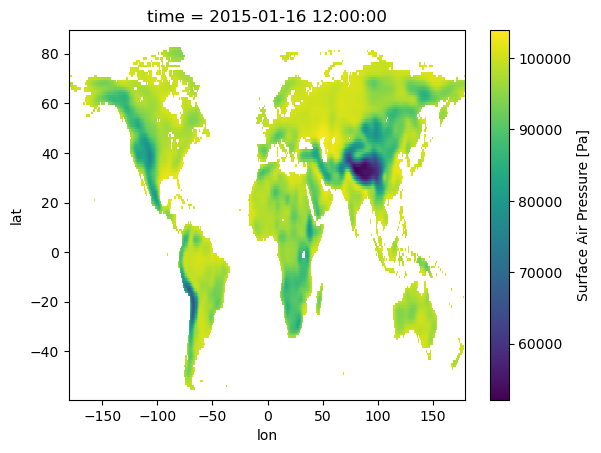

In [5]:
# ========= Have a look into the dictionary =======
print(list(ds_dict.keys()))
ds_dict[list(ds_dict.keys())[0]][models[0]][variables[0]].isel(time=0).plot()

### 2. Compute VPD

In [11]:
ds_dict_vpd = {}
ds_dict_vpd = compute_vpd(ds_dict[experiments[0]])

VPD computed and saved for BCC-CSM2-MR
VPD not computed for CAMS-CSM1-0 as variable(s) huss is/are missing
VPD computed and saved for CESM2-WACCM
VPD computed and saved for CNRM-ESM2-1
VPD computed and saved for GISS-E2-1-G
VPD computed and saved for MIROC-ES2L
VPD computed and saved for NorESM2-MM
VPD computed and saved for UKESM1-0-LL
VPD computed and saved for CanESM5
VPD computed and saved for CNRM-CM6-1
VPD computed and saved for GFDL-ESM4
VPD computed and saved for MPI-ESM1-2-LR
VPD computed and saved for TaiESM1


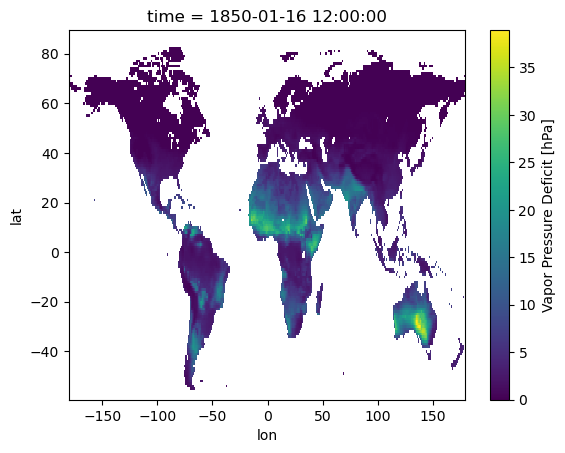

In [25]:
ds_dict_vpd[models[12]]['vpd'].isel(time=0).plot()

### 3. Save and replace netcdf files

In [26]:
# =========== Store file and remove any former one ==========
# Base directory
data_path = f'{data_state}/{data_product}/{experiments[0]}/{temp_res}/'
file_path = os.path.join(BASE_DIR, data_path)
print(file_path)

/work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/


In [27]:
sd.save_files(ds_dict_vpd, file_path)

File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/vpd/BCC-CSM2-MR.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/vpd/BCC-CSM2-MR.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/ps/CAMS-CSM1-0.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/ps/CAMS-CSM1-0.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/tas/CAMS-CSM1-0.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/tas/CAMS-CSM1-0.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/vpd/CESM2-WACCM.nc removed
File saved at: /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/vpd/CESM2-WACCM.nc
File /work/ch0636/g300115/phd_project/common/data/processed/CMIP6/historical/month/vpd/CNRM-ESM2-1.nc removed
File